In [ ]:
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization,Conv2DTranspose,Dropout
from keras.utils.vis_utils import plot_model
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import cv2
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input,Conv2D,Conv2DTranspose,Dropout,Concatenate,LeakyReLU,BatchNormalization,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# define downsampling block for Unet
def encoder_block(n_nodes,con_layer,batchNorm=True):
    #points from gaussian distribution
    init = RandomNormal(stddev=0.002)
    g = Conv2D(n_nodes,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(con_layer)
    
    if batchNorm:
        g = BatchNormalization()(g)
    
    g = LeakyReLU(0.2)(g)
    
    return g

In [ ]:
#define upsampling block for Unet
def decoder_block(n_nodes,con_layer,skip_layer,dropout=True):
    #points from gaussian distribution
    init = RandomNormal(stddev=0.002)
    g = Conv2DTranspose(n_nodes,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(con_layer)
    
    g = BatchNormalization()(g)
    
    if dropout:
        g = Dropout(0.2)(g)
        
    g = Concatenate()([g,skip_layer])
    
    g = Activation('relu')(g)
    
    return g

In [ ]:
# define unet model
def define_unet(img_shape=(256,256,3)):
    
    #getting points from gaussian distribution
    init = RandomNormal(stddev=0.02)
    inp = Input(shape=img_shape)
    
    #Downsampling layers
    e1 = encoder_block(64,inp,False)
    e2 = encoder_block(128,e1)
    e3 = encoder_block(256,e2)
    e4 = encoder_block(512,e3)
    e5 = encoder_block(512,e4)
    e6 = encoder_block(512,e5)
    e7 = encoder_block(512,e6)
    
    #Bottleneck layer
    b1 = Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(e7)
    b1 = Activation('relu')(b1)
    
    #Upsampling layers
    d1 = decoder_block(512,b1,e7)
    d2 = decoder_block(512,d1,e6)
    d3 = decoder_block(512,d2,e5)
    d4 = decoder_block(512,d3,e4,False)
    d5 = decoder_block(256,d4,e3,False)
    d6 = decoder_block(128,d5,e2,False)
    d7 = decoder_block(64,d6,e1,False)
    
    #Output layer 
    g = Conv2DTranspose(1,1,strides=(2,2),padding='same',activation='sigmoid')(d7)
    
    #define model
    model = Model(inp,g)
    
    return model
    
    

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip,ElasticTransform,GridDistortion

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
def load_data(path):
    # X = images and Y = mask
    train_x = sorted(glob(os.path.join(path,"training","images","*.tif")))
    train_y = sorted(glob(os.path.join(path,"training","1st_manual","*.gif")))
    
    test_x = sorted(glob(os.path.join(path,"test","images","*.tif")))
    test_y = sorted(glob(os.path.join(path,"test","1st_manual","*.gif")))
    
    return (train_x,train_y),(test_x,test_y)

In [ ]:
# load the data
(train_x,train_y),(test_x,test_y) = load_data('/content/drive/MyDrive/DRIVE')

In [ ]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

In [ ]:
test_x.shape

(5,)

In [ ]:
train_x.shape

(15,)

In [ ]:
#data augmentation

from tqdm import tqdm

def augment_data(images,mask,save_path,augment=True):
    H = 256
    W = 256

    print(save_path)
    
    for idx, (x,y) in tqdm(enumerate(zip(images,mask)),total=len(images)):
        #extracting names of the image
        name = x.split("/") [- 1] .split (".") [0]
        
        print(name)
        
        #Reading image and mask
        x = cv2.imread(x,cv2.IMREAD_COLOR)
        y = imageio.mimread(y)[0]
        
        #data augmentation
        if augment == True:
            # probability of horizantal flip applied to an image
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x,mask=y)
            x1 = augmented['image']
            y1 = augmented['mask']
            
            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x,mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']
            
            aug = ElasticTransform(p=1.0,alpha=120,sigma=120*0.05)
            augmented = aug(image=x,mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']
            
            aug = GridDistortion(p=1.0)
            augmented = aug(image=x,mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']
            
            X = [x,x1,x2,x3,x4]
            Y = [y,y1,y2,y3,y4]
        
        # no need to augment the data
        else:
            X = [x]
            Y = [y]
        
        index = 0
        for i,m in zip(X,Y):
            i = cv2.resize(i,(W,H))
            m = cv2.resize(m,(W,H))
            
            if len(X) == 1:
                tmp_image_name = f"{name}.jpg"
                tmp_mask_name = f"{name}.jpg"
            else:
                tmp_image_name = f"{name}_{index}.jpg"
                tmp_mask_name = f"{name}_{index}.jpg"
            
            
            image_path = os.path.join(save_path,"images",tmp_image_name)
            mask_path = os.path.join(save_path,"mask",tmp_mask_name)
            
            print(image_path)
            print(mask_path)
            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)
            
            index+=1
            
        

In [ ]:
print(train_x.shape)
print(train_y.shape)

(15,)
(15,)


In [ ]:
#create new directories
create_dir('/content/drive/MyDrive/new_drive_data/train/images')
create_dir('/content/drive/MyDrive/new_drive_data/train/mask')

create_dir('/content/drive/MyDrive/new_drive_data/test/images')
create_dir('/content/drive/MyDrive/new_drive_data/test/mask')

In [ ]:
augment_data(train_x,train_y,'/content/drive/MyDrive/new_drive_data/train',True)

  0%|          | 0/15 [00:00<?, ?it/s]

/content/drive/MyDrive/new_drive_data/train
21_training
/content/drive/MyDrive/new_drive_data/train/images/21_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/mask/21_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/images/21_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/mask/21_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/images/21_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/mask/21_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/images/21_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/mask/21_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/images/21_training_4.jpg

  7%|▋         | 1/15 [00:00<00:02,  4.89it/s]


/content/drive/MyDrive/new_drive_data/train/mask/21_training_4.jpg
22_training
/content/drive/MyDrive/new_drive_data/train/images/22_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/mask/22_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/images/22_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/mask/22_training_1.jpg


 13%|█▎        | 2/15 [00:00<00:02,  4.63it/s]

/content/drive/MyDrive/new_drive_data/train/images/22_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/mask/22_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/images/22_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/mask/22_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/images/22_training_4.jpg
/content/drive/MyDrive/new_drive_data/train/mask/22_training_4.jpg
23_training
/content/drive/MyDrive/new_drive_data/train/images/23_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/mask/23_training_0.jpg


 20%|██        | 3/15 [00:00<00:02,  4.61it/s]

/content/drive/MyDrive/new_drive_data/train/images/23_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/mask/23_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/images/23_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/mask/23_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/images/23_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/mask/23_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/images/23_training_4.jpg
/content/drive/MyDrive/new_drive_data/train/mask/23_training_4.jpg
24_training


 27%|██▋       | 4/15 [00:00<00:02,  4.44it/s]

/content/drive/MyDrive/new_drive_data/train/images/24_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/mask/24_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/images/24_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/mask/24_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/images/24_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/mask/24_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/images/24_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/mask/24_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/images/24_training_4.jpg
/content/drive/MyDrive/new_drive_data/train/mask/24_training_4.jpg
25_training


 33%|███▎      | 5/15 [00:01<00:02,  4.35it/s]

/content/drive/MyDrive/new_drive_data/train/images/25_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/mask/25_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/images/25_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/mask/25_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/images/25_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/mask/25_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/images/25_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/mask/25_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/images/25_training_4.jpg
/content/drive/MyDrive/new_drive_data/train/mask/25_training_4.jpg
26_training


 40%|████      | 6/15 [00:01<00:02,  4.39it/s]

/content/drive/MyDrive/new_drive_data/train/images/26_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/mask/26_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/images/26_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/mask/26_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/images/26_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/mask/26_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/images/26_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/mask/26_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/images/26_training_4.jpg
/content/drive/MyDrive/new_drive_data/train/mask/26_training_4.jpg
27_training


 47%|████▋     | 7/15 [00:01<00:01,  4.35it/s]

/content/drive/MyDrive/new_drive_data/train/images/27_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/mask/27_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/images/27_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/mask/27_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/images/27_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/mask/27_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/images/27_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/mask/27_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/images/27_training_4.jpg
/content/drive/MyDrive/new_drive_data/train/mask/27_training_4.jpg
28_training


 53%|█████▎    | 8/15 [00:01<00:01,  4.44it/s]

/content/drive/MyDrive/new_drive_data/train/images/28_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/mask/28_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/images/28_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/mask/28_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/images/28_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/mask/28_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/images/28_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/mask/28_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/images/28_training_4.jpg
/content/drive/MyDrive/new_drive_data/train/mask/28_training_4.jpg
29_training


 60%|██████    | 9/15 [00:02<00:01,  4.38it/s]

/content/drive/MyDrive/new_drive_data/train/images/29_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/mask/29_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/images/29_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/mask/29_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/images/29_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/mask/29_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/images/29_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/mask/29_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/images/29_training_4.jpg
/content/drive/MyDrive/new_drive_data/train/mask/29_training_4.jpg
30_training


 67%|██████▋   | 10/15 [00:02<00:01,  4.45it/s]

/content/drive/MyDrive/new_drive_data/train/images/30_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/mask/30_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/images/30_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/mask/30_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/images/30_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/mask/30_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/images/30_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/mask/30_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/images/30_training_4.jpg
/content/drive/MyDrive/new_drive_data/train/mask/30_training_4.jpg
31_training


 73%|███████▎  | 11/15 [00:02<00:00,  4.31it/s]

/content/drive/MyDrive/new_drive_data/train/images/31_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/mask/31_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/images/31_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/mask/31_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/images/31_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/mask/31_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/images/31_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/mask/31_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/images/31_training_4.jpg
/content/drive/MyDrive/new_drive_data/train/mask/31_training_4.jpg
32_training


 80%|████████  | 12/15 [00:02<00:00,  4.38it/s]

/content/drive/MyDrive/new_drive_data/train/images/32_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/mask/32_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/images/32_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/mask/32_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/images/32_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/mask/32_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/images/32_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/mask/32_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/images/32_training_4.jpg
/content/drive/MyDrive/new_drive_data/train/mask/32_training_4.jpg
33_training


 87%|████████▋ | 13/15 [00:02<00:00,  4.35it/s]

/content/drive/MyDrive/new_drive_data/train/images/33_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/mask/33_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/images/33_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/mask/33_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/images/33_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/mask/33_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/images/33_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/mask/33_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/images/33_training_4.jpg
/content/drive/MyDrive/new_drive_data/train/mask/33_training_4.jpg
34_training


 93%|█████████▎| 14/15 [00:03<00:00,  4.26it/s]

/content/drive/MyDrive/new_drive_data/train/images/34_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/mask/34_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/images/34_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/mask/34_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/images/34_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/mask/34_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/images/34_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/mask/34_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/images/34_training_4.jpg
/content/drive/MyDrive/new_drive_data/train/mask/34_training_4.jpg
35_training


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]

/content/drive/MyDrive/new_drive_data/train/images/35_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/mask/35_training_0.jpg
/content/drive/MyDrive/new_drive_data/train/images/35_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/mask/35_training_1.jpg
/content/drive/MyDrive/new_drive_data/train/images/35_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/mask/35_training_2.jpg
/content/drive/MyDrive/new_drive_data/train/images/35_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/mask/35_training_3.jpg
/content/drive/MyDrive/new_drive_data/train/images/35_training_4.jpg
/content/drive/MyDrive/new_drive_data/train/mask/35_training_4.jpg


In [ ]:
print(test_x.shape)
print(test_y.shape)

(5,)
(5,)


In [ ]:
augment_data(test_x,test_y,'/content/drive/MyDrive/new_drive_data/test',False)

  0%|          | 0/5 [00:00<?, ?it/s]

/content/drive/MyDrive/new_drive_data/test
1_test


 20%|██        | 1/5 [00:01<00:07,  1.83s/it]

/content/drive/MyDrive/new_drive_data/test/images/1_test.jpg
/content/drive/MyDrive/new_drive_data/test/mask/1_test.jpg
2_test


 40%|████      | 2/5 [00:03<00:05,  1.74s/it]

/content/drive/MyDrive/new_drive_data/test/images/2_test.jpg
/content/drive/MyDrive/new_drive_data/test/mask/2_test.jpg
3_test


 60%|██████    | 3/5 [00:04<00:03,  1.68s/it]

/content/drive/MyDrive/new_drive_data/test/images/3_test.jpg
/content/drive/MyDrive/new_drive_data/test/mask/3_test.jpg
4_test


 80%|████████  | 4/5 [00:06<00:01,  1.74s/it]

/content/drive/MyDrive/new_drive_data/test/images/4_test.jpg
/content/drive/MyDrive/new_drive_data/test/mask/4_test.jpg
5_test


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]

/content/drive/MyDrive/new_drive_data/test/images/5_test.jpg
/content/drive/MyDrive/new_drive_data/test/mask/5_test.jpg


In [ ]:
# directory to save files
create_dir("/content/drive/MyDrive/files")

#Hyperparameters
batch_size=2
lr = 1e-4
num_epochs = 100
model_path = os.path.join("/content/drive/MyDrive/files","model.h5")
csv_path = os.path.join("/content/drive/MyDrive/files","data.csv")

In [ ]:
# Dataset
dataset_path = "/content/drive/MyDrive/new_drive_data"
train_path = os.path.join(dataset_path,"train")
valid_path = os.path.join(dataset_path,"test")

In [ ]:
def load_path(path):
    X = sorted(glob(os.path.join(path,"images","*.jpg")))
    Y = sorted(glob(os.path.join(path,"mask","*.jpg")))
    
    return X,Y

In [ ]:
from sklearn.utils import shuffle
def shuffling(x,y):
    x,y = shuffle(x,y)
    return x,y

In [ ]:
#Load and shuffle the data
train_x,train_y = load_path(train_path)
train_x,train_y = shuffling(train_x,train_y)

In [ ]:
valid_x, valid_y = load_path(valid_path)

In [ ]:
print(len(train_x))

75


In [ ]:
print(len(valid_x))

5


In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path,cv2.IMREAD_COLOR)
  #  x = cv2.resize(x,(256,256))
    x = x/255.0
    x = x.astype(np.float32)
    return x

In [ ]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
  #  x = cv2.resize(x,(256,256))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x,axis=-1) #(256,256,1)
    return x

In [ ]:
import tensorflow as tf
import numpy as np
from glob import glob
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,ReduceLROnPlateau,TensorBoard,EarlyStopping
from tensorflow.keras.metrics import Recall,Precision


In [ ]:
def tf_parse(x,y):
    def _parse(x,y):
        x= read_image(x)
        y = read_mask(y)
        return x,y
    x,y = tf.numpy_function(_parse,[x,y],[tf.float32,tf.float32])
    x.set_shape([256,256,3])
    y.set_shape([256,256,1])
    return x,y
    

In [ ]:
def tf_dataset(X,Y,batch_size=2):
    dataset = tf.data.Dataset.from_tensor_slices((X,Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(4)
    return dataset

In [ ]:
valid_x = np.array(valid_x)
valid_y = np.array(valid_y)
train_x = np.array(train_x)
train_y = np.array(train_y)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(75,)
(75,)
(5,)
(5,)


In [ ]:
print(train_x[0])

/content/drive/MyDrive/new_drive_data/train/images/30_training_0.jpg


In [ ]:
train_dataset = tf_dataset(train_x,train_y)
valid_dataset = tf_dataset(valid_x,valid_y)

In [ ]:
#no of steps
train_steps = len(train_x)//batch_size
test_steps = len(valid_x)//batch_size

In [ ]:
print(train_steps)
print(test_steps)


37
2


In [ ]:
if len(train_x) % batch_size != 0:
    train_steps +=1
if len(valid_x) % batch_size != 0:
    test_steps +=1

In [ ]:
print(train_steps)
print(test_steps)

39
4


In [ ]:
def iou(y_true,y_pred):
    def f(y_true,y_pred):
        intersection = (y_true*y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f,[y_true,y_pred],tf.float32)

In [ ]:
smooth = 1e-15
def dice_coef(y_true,y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true*y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [ ]:
def dice_loss(y_true,y_pred):
    return 1.0 - dice_coef(y_true,y_pred)

In [ ]:
model = define_unet()

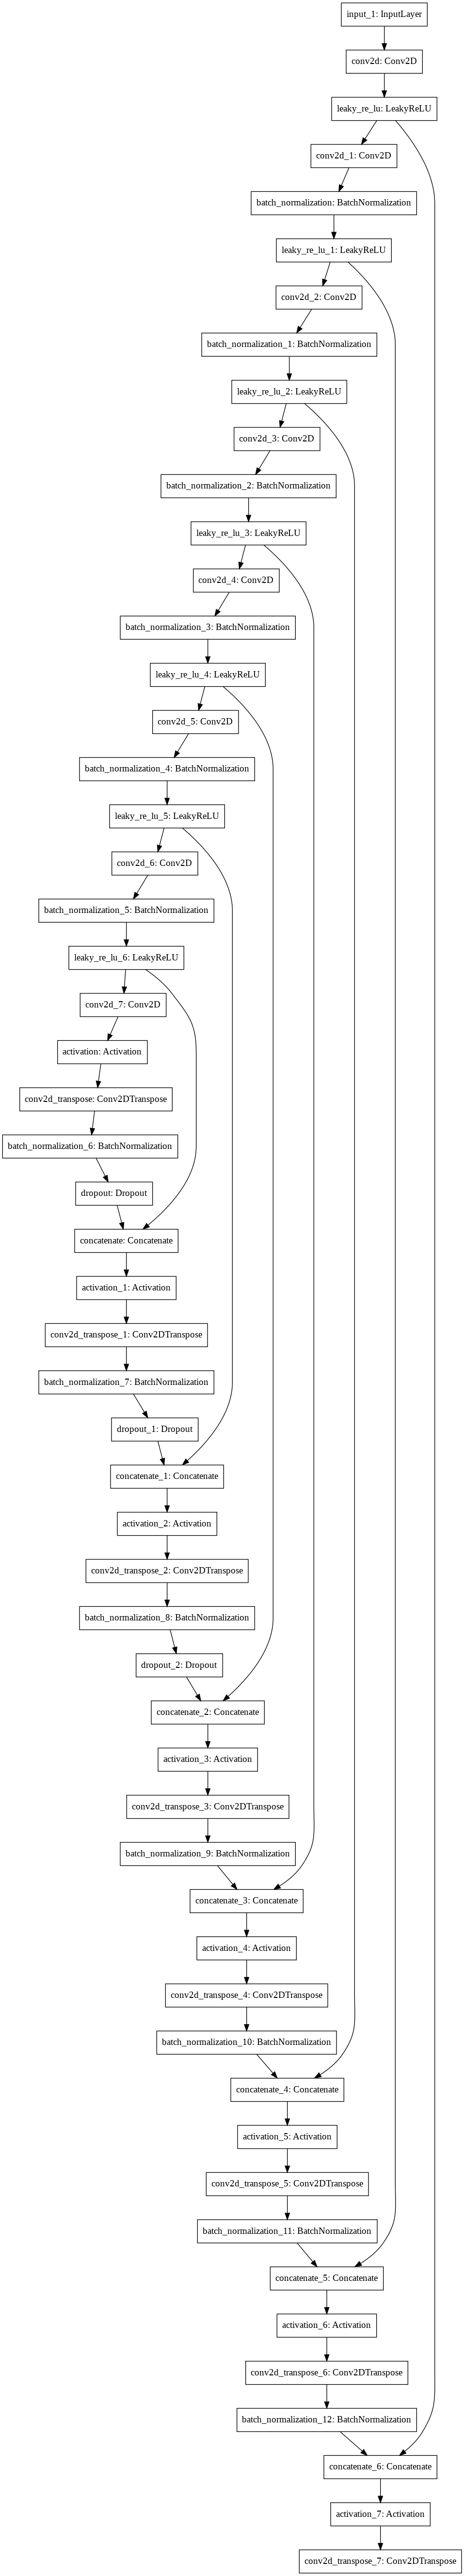

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='LanguageModellingGraph.png')

In [ ]:
model.compile(loss=dice_loss,optimizer=Adam(lr),metrics=[dice_coef,iou,Recall(),Precision()])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 3136        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [ ]:
#it will run during the training
callbacks = [
    ModelCheckpoint(model_path,verbose=1,save_best_only=True),
    CSVLogger(csv_path)    
]

In [ ]:
model.fit(
        train_dataset,
        epochs=500,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=test_steps,
        callbacks=callbacks)

Epoch 1/500
38/38 [==============================] - 75s 1s/step - loss: 0.8322 - dice_coef: 0.1678 - iou: 0.0917 - recall: 0.9393 - precision: 0.2951 - val_loss: 0.8479 - val_dice_coef: 0.1490 - val_iou: 0.0805 - val_recall: 0.7497 - val_precision: 0.2847

Epoch 00001: val_loss improved from inf to 0.84790, saving model to /content/drive/MyDrive/files/model.h5
Epoch 2/500
38/38 [==============================] - 3s 89ms/step - loss: 0.8293 - dice_coef: 0.1708 - iou: 0.0935 - recall: 0.9614 - precision: 0.2964 - val_loss: 0.8485 - val_dice_coef: 0.1484 - val_iou: 0.0802 - val_recall: 0.7497 - val_precision: 0.2847

Epoch 00002: val_loss did not improve from 0.84790
Epoch 3/500
38/38 [==============================] - 3s 91ms/step - loss: 0.8288 - dice_coef: 0.1713 - iou: 0.0938 - recall: 0.9590 - precision: 0.2964 - val_loss: 0.8492 - val_dice_coef: 0.1478 - val_iou: 0.0798 - val_recall: 0.7497 - val_precision: 0.2847

Epoch 00003: val_loss did not improve from 0.84790
Epoch 4/500
38/3

In [ ]:
model.save('/content/drive/MyDrive/500epochs_model_vsl_loss.h5')

In [ ]:
def read_image(path):
    x = cv2.imread(path,cv2.IMREAD_COLOR)
  #  x = cv2.resize(x,(256,256))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x,x

In [ ]:
def read_mask(path):
    x = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
  #  x = cv2.resize(x,(256,256))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    x = np.expand_dims(x,axis=-1) #(256,256,1)
    return ori_x,x

In [ ]:
def load_path(path):
    x = sorted(glob(os.path.join(path,"images","*.jpg")))
    y = sorted(glob(os.path.join(path,"mask","*.jpg")))
    return x,y

In [ ]:
# Load the model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
with CustomObjectScope({'iou':iou,'dice_coef':dice_coef,'dice_loss':dice_loss}):
    model1 = load_model("100epochs_model.h5") 

OSError: ignored

In [ ]:
dataset_path = os.path.join("/content/drive/MyDrive/new_drive_data","test")

In [ ]:
test_x,test_y = load_path(dataset_path)

In [ ]:
print(len(test_x))
print(len(test_y))

5
5


In [ ]:
from sklearn.metrics import accuracy_score,f1_score,jaccard_score,recall_score,precision_score
def save_results(ori_x,ori_y,y_pred,save_image_path):
    line = np.ones((256,10,3))*255
    
    ori_y = np.expand_dims(ori_y,axis=-1)
    ori_y = np.concatenate([ori_y,ori_y,ori_y],axis=-1) 

    y_pred = np.expand_dims(y_pred,axis=-1)
    y_pred = np.concatenate([y_pred,y_pred,y_pred],axis=-1) * 255
    
    print(y_pred.shape)
    print(ori_x.shape)
    
    cat_images = np.concatenate([ori_x,line,ori_y,line,y_pred],axis=1)
    cv2.imwrite(save_image_path,cat_images)

In [ ]:
import matplotlib.pyplot as plt
#Make prediction and calculate the metrics value
def make_Predictions(mask_index,model):

  index=0
  score = []
  for x,y in tqdm(zip(test_x,test_y),total=len(test_x)):
    #extracting names of the image
    name = x.split ("\\") [- 1] .split (".") [0]
        
    #Read the image and mask
    ori_x,x = read_image(x) #(256,256,3)
    ori_y,y = read_mask(y)
        
    #Prediction
    y_pred = model.predict(np.expand_dims(x,axis=0))[0] # (1,256,256,3)
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    print(y_pred.shape)
    y_pred = np.squeeze(y_pred,axis=-1)
    print(y_pred.shape)
            
        
    #Save the images    
    save_image_path = f"/content/drive/MyDrive/results/(name)_{index+mask_index}.png"
    save_results(ori_x,ori_y,y_pred,save_image_path)

    #Flatten the array
    y = y.flatten()
    y_pred = y_pred.flatten()

    #Calculate the metrics 
    acc_value = accuracy_score(y,y_pred)
    f1_score = f1_score(y,y_pred,labels=[0,1],average="binary")
    jac_value = jaccard_score(y,y_pred,labels=[0,1],average='binary')
    recall_value = recall_score(y,y_pred,labels=[0,1],average='binary')
    precision_score_value = precision_score(y,y_pred,labels=[0,1],average='binary')

    score.append([name,acc_value,f1_score,jac_value,recall_value,precision_score_value])

    index +=1

  score = [s[1:] for s in SCORE]
  score = np.mean(score,axis=0)
  print("Accuracy:",score[0])
  print("F1_score:",score[1])
  print("jac_value:",score[2])
  print("Recall_value:",score[3])
  print("Precision_score_value:",score[4])

In [ ]:
def 

Transfer Learning


In [ ]:
def conv_block(inputs,num_filters):
  x = Conv2D(num_filters,3,padding='same')(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(num_filters,3,padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

In [ ]:
def define_decoder(inputs,skip_layer,num_filters):
  init = RandomNormal(stddev=0.02)
  x = Conv2DTranspose(num_filters,(2,2),strides=(2,2),padding='same',kernel_initializer=init)(inputs)
  g = Concatenate()([x,skip_layer])
  g = conv_block(g,num_filters)
  return g

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input,Conv2DTranspose,BatchNormalization,Dropout,Concatenate,Activation,Conv2D
from keras.models import Model
from keras.initializers import RandomNormal

In [ ]:
vgg16 = VGG16(include_top=False,weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
def vgg16_unet(input_shape):
  inputs = Input(shape=input_shape)
  vgg16 = VGG16(include_top=False,weights='imagenet',input_tensor=inputs)

  # We will extract encoder layers based on their output shape from vgg16 model
  s1 = vgg16.get_layer('block1_conv2').output  #512
  s2 = vgg16.get_layer('block2_conv2').output  #256
  s3 = vgg16.get_layer('block3_conv3').output  #128
  s4 = vgg16.get_layer('block4_conv3').output  #64

  # bottleneck/bridege layer from vgg16
  b1 = vgg16.get_layer('block5_conv3').output #32

  # Decoder Block 
  d1 = define_decoder(b1,s4,512)
  d2 = define_decoder(d1,s3,256)
  d3 = define_decoder(d2,s2,128)
  d4 = define_decoder(d3,s1,64)

  #output layer 
  outputs = Conv2D(1,1,padding='same',activation='sigmoid')(d4)

  model = Model(inputs,outputs)

  return model

In [ ]:
model = vgg16_unet((256,256,3))
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
_____________________________

In [ ]:
model.compile(loss=dice_loss,optimizer=Adam(lr),metrics=[dice_coef,iou,Recall(),Precision()])

In [ ]:
model.fit(
        train_dataset,
        epochs=100,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=test_steps,
        callbacks=callbacks)

NameError: ignored

In [ ]:
model.fit(
        train_dataset,
        epochs=500,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=test_steps)

Epoch 1/500
38/38 [==============================] - 129s 2s/step - loss: 0.7082 - dice_coef: 0.2929 - iou: 0.1736 - recall_3: 0.7010 - precision_3: 0.4082 - val_loss: 0.8262 - val_dice_coef: 0.1700 - val_iou: 0.0930 - val_recall_3: 0.6496 - val_precision_3: 0.4423
Epoch 2/500
38/38 [==============================] - 16s 433ms/step - loss: 0.5560 - dice_coef: 0.4444 - iou: 0.2866 - recall_3: 0.5822 - precision_3: 0.4721 - val_loss: 0.7767 - val_dice_coef: 0.2185 - val_iou: 0.1228 - val_recall_3: 0.5401 - val_precision_3: 0.4930
Epoch 3/500
38/38 [==============================] - 16s 434ms/step - loss: 0.4883 - dice_coef: 0.5116 - iou: 0.3443 - recall_3: 0.5083 - precision_3: 0.5160 - val_loss: 0.7326 - val_dice_coef: 0.2614 - val_iou: 0.1505 - val_recall_3: 0.4862 - val_precision_3: 0.5355
Epoch 4/500
38/38 [==============================] - 17s 437ms/step - loss: 0.4549 - dice_coef: 0.5449 - iou: 0.3750 - recall_3: 0.4680 - precision_3: 0.5545 - val_loss: 0.6272 - val_dice_coef: 0.36

In [ ]:
model.save('/content/drive/MyDrive/vggUnetmodel500epochs.h5')

In [ ]:
make_Predictions(500,model)

 20%|██        | 1/5 [00:01<00:07,  1.90s/it]

(256, 256, 1)
(256, 256)
(256, 256, 3)
(256, 256, 3)


 40%|████      | 2/5 [00:02<00:04,  1.39s/it]

(256, 256, 1)
(256, 256)
(256, 256, 3)
(256, 256, 3)
(256, 256, 1)
(256, 256)
(256, 256, 3)


 80%|████████  | 4/5 [00:02<00:00,  1.26it/s]

(256, 256, 3)
(256, 256, 1)
(256, 256)
(256, 256, 3)
(256, 256, 3)


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

(256, 256, 1)
(256, 256)
(256, 256, 3)
(256, 256, 3)


In [ ]:
dec = define_decoder()